# Adaptive hyperparameter optimization
This notebook shows off a model selection algorithm that is now a part of Dask-ML, Hyperband.

## Problem
Any machine learning model requires tuning many "hyper-parameters" for good performance, and is mentioned in the Scikit-Learn docs under "[Tuning the hyper-parameters of an estimator]".

This notebook will walk through a case of "image denoising". Getting good performance out of this model requires tuning these parameters:

``` python
params = {
    'module__init',
    'module__activation',
    'optimizer',
    'batch_size',
    'optimizer__lr',
    'optimizer__weight_decay',
}
```

These are incredibly important, and fairly basic. They answer the questions of

* How is the network initialization?
* How is the model optimized? What are some of the hyper-parameters for `optimizer`?

[Tuning the hyper-parameters of an estimator]:http://scikit-learn.org/stable/modules/grid_search.html


This notebook looks at a realistic use case of hyperparameter optimization. To do this, this notebook uses

* a realistic deep learning model
* a realistic set of hyperparameters

There are many hyperparameter for any model or framework. These can be specific to the model, or be related to the optimization framework used to minimize the model.

This notebook will show

* the model input and output (noisy and clean images respectively)
* the parameter space we are searching over
* a newly developed hyperparameter optimization algorithm and it's integration
* a comparison with 3 hyperparameter selection algorithms

## Setup

In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

In [1]:
import distributed
from distributed import Client
client = Client()
client

Client Scheduler: tcp://127.0.0.1:64121 Dashboard: http://127.0.0.1:8787/status,Cluster Workers: 4 Cores: 4 Memory: 8.59 GB


In [3]:
import subprocess
def debug_loop():
    subprocess.call("pip install git+https://github.com/stsievert/dask-ml@hyperband-scale".split(" "))
    import dask_ml
    return dask_ml.__version__

In [ ]:
%time debug_loop()

In [ ]:
%time client.run(debug_loop)

In [ ]:
%time client.restart()

In [3]:
%time client.upload_file('autoencoder.py')

CPU times: user 217 ms, sys: 40.7 ms, total: 258 ms
Wall time: 3.11 s


In [2]:
import dask_ml
from dask_ml.model_selection import HyperbandSearchCV
import dask_ml
dask_ml.__version__

'0.4.2.dev255+g9dcde9c'

## Data
See below for an image.

In [4]:
import noisy_mnist
_X, _y = noisy_mnist.dataset()#n=10 * 1024)

Using TensorFlow backend.


In [5]:
import dask.array as da
n, d = _X.shape
X = da.from_array(_X, chunks=(n // 2, d))
y = da.from_array(_y, chunks=n // 2)
X, y

(dask.array<array, shape=(70000, 784), dtype=float32, chunksize=(35000, 784)>,
 dask.array<array, shape=(70000, 784), dtype=float32, chunksize=(35000, 784)>)

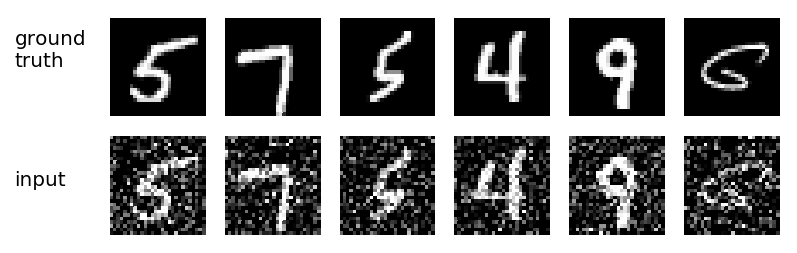

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
cols = 6
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 2*w), ncols=cols, nrows=2)
for col, (upper, lower) in enumerate(zip(axs[0], axs[1])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        lower.text(-28, 14, 'input')
    i = np.random.choice(len(X))
    noisy = X[i].reshape(28, 28)
    clean = y[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray'}
    sns.heatmap(noisy, ax=lower, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
plt.savefig("imgs/input-output.svg", bbox_inches="tight")
plt.show()

## Model

I use a deep learning library (PyTorch) for this model, at least through the scikit-learn interface for PyTorch, [skorch].

[skorch]:https://github.com/dnouri/skorch

In [7]:
from autoencoder import Autoencoder, NegLossScore
import torch

model = NegLossScore(
    module=Autoencoder,
    criterion=torch.nn.BCELoss,
    warm_start=True,
    train_split=None,
    max_epochs=1,
    callbacks=[]
)

I don't show it here; I'd rather concentrate on tuning hyperparameters. But briefly, it's a simple fully connected 3 hidden layer autoencoder with a latent dimension of 49.

## Parameters

The parameters I am interested in tuning are

* model
    * initialization
    * activation function
    * weight decay (which is similar to $\ell_2$ regularization)
* optimizer
    * which optimizer to use (e.g., Adam, SGD)
    * batch size used to approximate gradient
    * learning rate (but not for Adam)
    * momentum for SGD
    
After looking at the results, I think I was too exploratory in my tuning of step size. I should have experimented with it more to determine a reasonable range.

In [8]:
import numpy as np

params = {
    'module__init': ['xavier_uniform_',
                     'xavier_normal_',
                     'kaiming_uniform_',
                     'kaiming_normal_',
                    ],
    'module__activation': ['ReLU', 'LeakyReLU', 'ELU', 'PReLU'],
    'optimizer': ['SGD'] * 5 + ['Adam'] * 2,
    'batch_size': [32, 64, 128, 256, 512],
    'optimizer__lr': np.logspace(1, -1.5, num=1000),
    'optimizer__weight_decay': [0]*200 + np.logspace(-5, -3, num=1000).tolist(),
    'optimizer__nesterov': [True],
    'optimizer__momentum': np.linspace(0, 1, num=1000),
    'train_split': [None],
}

I am testing `optimizer` to be `SGD` or `Adam` to test "[The Marginal Value of Adaptive Gradient Methods in Machine Learning][marginal]". From their abstract,

> We observe that the solutions found by adaptive methods generalize worse (often sig- nificantly worse) than SGD, even when these solutions have better training performance. These results suggest that practitioners should reconsider the use of adaptive methods to train neural networks.

Their experiments in Figure 1b show that non-adaptive methods (SGD and heavy ball) perform much better than adaptive methods.

They have to do some tuning for this. **Can we replicate their result?**

[marginal]:https://arxiv.org/pdf/1705.08292.pdf

In [9]:
from sklearn.model_selection import ParameterSampler
import torch

def trim_params(**kwargs):
    if kwargs['optimizer'] != 'Adam':
        kwargs.pop('optimizer__amsgrad', None)
    if kwargs['optimizer'] == 'Adam':
        kwargs.pop('optimizer__lr', None)
    if kwargs['optimizer'] != 'SGD':
        kwargs.pop('optimizer__nesterov', None)
        kwargs.pop('optimizer__momentum', None)
    kwargs['optimizer'] = getattr(torch.optim, kwargs['optimizer'])
    return kwargs

param_list = [trim_params(**param)
              for param in ParameterSampler(params, int(1e4))]

In [3]:
# # for debugging; ignore this cell
from sklearn.linear_model import SGDClassifier
from sklearn.datasets import make_classification
from sklearn.model_selection import ParameterSampler
import dask.array as da
import numpy as np
model = SGDClassifier()
params = {'alpha': np.logspace(-7, 0, num=int(1e6))}

n, d = int(10e3), 700
_X, _y = make_classification(n_samples=n, n_features=d,
                             random_state=1)
X = da.from_array(_X, chunks=(n // 10, d))
y = da.from_array(_y, chunks=n // 10)
X, y

(dask.array<array, shape=(10000, 700), dtype=float64, chunksize=(1000, 700)>,
 dask.array<array, shape=(10000,), dtype=int64, chunksize=(1000,)>)

## Hyperparameter optimization

In [4]:
from dask_ml.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y)

In [5]:
from sklearn.linear_model import SGDClassifier

max_iter = 27
history = {}
cv_results = {}
searches = {}

In [6]:
from dask_ml.model_selection import HyperbandSearchCV

fit_params = {}
if isinstance(model, SGDClassifier):
    fit_params = {'classes': da.unique(y).compute()}
    
adapt_searches = [HyperbandSearchCV(model, params, max_iter, random_state=i)
            for i in range(10)]

In [7]:
_ = [search.fit(X_train, y_train, **fit_params)
     for search in adapt_searches]

In [10]:
search = adapt_searches[0]

In [11]:
search.best_estimator_

SGDClassifier(alpha=0.5665284878526908, average=False, class_weight=None,
       early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
       l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
       n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
       power_t=0.5, random_state=None, shuffle=True, tol=None,
       validation_fraction=0.1, verbose=0, warm_start=False)

In [12]:
search.best_score_

0.8733333333333333

In [13]:
search.best_params_

{'alpha': 0.5665284878526908}

In [15]:
history["hyperband"] = [s.history_ for s in adapt_searches]
cv_results["hyperband"] = [s.cv_results_ for s in adapt_searches]
searches["hyperband"] = adapt_searches

### Visualizing output of best estimator

In [15]:
noisy_test = X_test.compute()

In [16]:
clean_hat = search.best_estimator_.predict(noisy_test)
clean_hat.shape

(1000,)

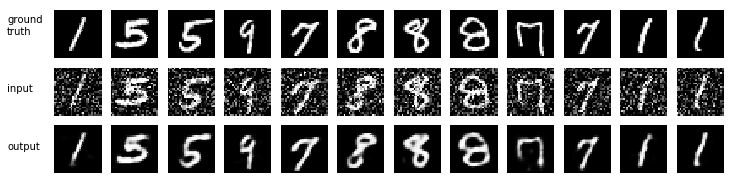

In [59]:
cols = 5
w = 1.0
fig, axs = plt.subplots(figsize=(cols*w, 3*w), ncols=cols, nrows=3)
for col, (upper, middle, lower) in enumerate(zip(axs[0], axs[1], axs[2])):
    if col == 0:
        upper.text(-28, 14, 'ground\ntruth')
        middle.text(-28, 14, 'input')
        lower.text(-28, 14, 'output')
    i = np.random.choice(len(X_test))
    noisy = X_test[i].reshape(28, 28)
    clean = y_test[i].reshape(28, 28)
    clean_hat_i = clean_hat[i].reshape(28, 28)
    kwargs = {'cbar': False, 'xticklabels': False, 'yticklabels': False, 'cmap': 'gray'}
    sns.heatmap(noisy, ax=middle, **kwargs)
    sns.heatmap(clean, ax=upper, **kwargs)
    sns.heatmap(clean_hat_i, ax=lower, **kwargs)
plt.show()

### Setting parameters for Hyperband
Need to know two things:

1. how many "epochs" or "passes through data" to train model
2. how many configs to evaluate
    * this is some measure of how complex the search space is
    
This determines

* The `max_iter` argument for `HyperbandCV`
* the chunks size for the array to pass in


## Comparison with early stopping

In [16]:
total_calls = search.metadata_['partial_fit_calls']
num_calls = max_iter

num_models = max(sum(client.ncores().values()), total_calls // num_calls)
num_calls, num_models, search.metadata_['partial_fit_calls']

(27, 13, 357)

In [17]:
from dask_ml.model_selection import IncrementalSearchCV

passive_searches = [IncrementalSearchCV(
    model, params,
    decay_rate=0,
    patience=False,
    n_initial_parameters=num_models,
    max_iter=num_calls,
    random_state=i,
) for i in range(10)]

In [18]:
_ = [passive_search.fit(X_train, y_train, **fit_params)
 for passive_search in passive_searches]

[IncrementalSearchCV(decay_rate=0,
           estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_t=0.5, random_state=None, shuffle=True, tol=None,
        validation_fraction=0.1, verbose=0, warm_start=False),
           max_iter=27, n_initial_parameters=13, param_distribution=None,
           patience=False, random_state=0, scores_per_fit=1, scoring=None,
           test_size=None, tol=0.001), IncrementalSearchCV(decay_rate=0,
           estimator=SGDClassifier(alpha=0.0001, average=False, class_weight=None,
        early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
        l1_ratio=0.15, learning_rate='optimal', loss='hinge', max_iter=None,
        n_iter=None, n_iter_no_change=5, n_jobs=None, penalty='l2',
        power_

In [19]:
history["passive"] = [ps.history_ for ps in passive_searches]
cv_results["passive"] = [ps.cv_results_ for ps in passive_searches]
searches["passive"] = passive_searches

In [20]:
patience_searches = [IncrementalSearchCV(
    model,
    params,
    decay_rate=0,
    patience=max_iter // 5,
    n_initial_parameters=2 * num_models,
    max_iter=num_calls,
    random_state=i,
) for i in range(10)]

In [21]:
_ = [patience_search.fit(X_train, y_train, **fit_params)
     for patience_search in patience_searches]

In [22]:
history["patience"] = [ps.history_ for ps in patience_searches]
cv_results["patience"] = [ps.cv_results_ for ps in patience_searches]
searches["patience"] = patience_searches

In [23]:
import json
import msgpack

def fmt(obj):
    if isinstance(obj, list):
        return [fmt(v) for v in obj]
    if isinstance(obj, dict):
        return {k: fmt(v) for k, v in obj.items()}
    if isinstance(obj, np.ndarray):
        return obj.tolist()
    return obj

today = "2018-11-07"

In [25]:
import msgpack
from sklearn.externals import joblib
with open(f'{today}-searches.joblib', 'wb') as f:
    joblib.dump(searches, f)

In [ ]:
with open(f'{today}-history.json', 'w') as f:
    json.dump(history, f)
    
with open(f'{today}-cv_results.json', 'w') as f:
    json.dump(fmt(cv_results), f)